In [4]:
import sys
sys.path.append("/home/pcl/8LStudentYuHaitao/sfp-eval")
tmp = 'result/select-ntp-stat.json'
import json
import random
import pyasn
from matplotlib import pyplot as plt
from pytricia import PyTricia
from networkx import DiGraph, Graph

import seaborn as sns
import pandas as pd
import multiprocessing


from as_rel import load_as_rel
from sfp_eval.correctness.advertise import fp_bgp_advertise

#####################################################################

DEFAULT_ASNDB = '../sfp-eval/ipasn.20190116.1600.dat'
asndb = pyasn.pyasn(DEFAULT_ASNDB)


def load_as_graph():
    return load_as_rel("../sfp-eval/20181201.as-rel.txt")


def load_stub_str_list():
    with open('../sfp-eval/stubs.txt') as f:
        t = str(f.read())
        stubs = t.split()
    return stubs

#####################################################################


def update_initial_rib(rib, prefix, overwrite=True):
    if overwrite or prefix not in rib:
        rib[prefix] = {0: []}
    else:
        rib[prefix].update({0: []})


def transform(g : Graph, c_as):
    g.ip_prefixes = PyTricia()
    for n in g.nodes():
        cust = set()
        prov = set()
        peer = set()
        for n1,n2 in g.edges(n):
            e=g.edges[n1, n2]
            if e['rel'] == 'pc':
                cust.add(n2)
            elif e['rel'] == 'cp':
                prov.add(n2)
            elif e['rel'] == 'pp':
                peer.add(n2)
        # g.node[n]['asn'] = n
        g.node[n]['customers'] = cust
        g.node[n]['providers'] = prov
        g.node[n]['peers'] = peer
        g.node[n]['ip-prefixes'] = set()
        # g.node[n]['ip'] = None
    g.node[c_as]['ip-prefixes'].add("1.1.1.1/24")

    g.ip_prefixes["1.1.1.1/24"]=c_as
    for node_id in g.nodes():
        node_obj = g.node[node_id]
        node_obj['adj-ribs-in'] = {n: PyTricia() for n in g.neighbors(node_id)}
        node_obj['rib'] = PyTricia()
        node_obj['adj-ribs-out'] = {n: PyTricia() for n in g.neighbors(node_id)}
        node_obj['local_policy'] = PyTricia()

    for n in g.nodes():
        g.node[n]['rib'] = PyTricia()
        for prefix in g.node[n]['ip-prefixes']:
            update_initial_rib(g.node[n]['rib'], prefix, True)
            # out_ribs = G.node[n]['adj-ribs-out']
            # for d in out_ribs:
            #     update_initial_rib(out_ribs[d], prefix, n)
        g.node[n]['adj-ribs-in'] = {n: PyTricia() for n in g.neighbors(n)}
        g.node[n]['adj-ribs-out'] = {n: PyTricia() for n in g.neighbors(n)}


def fp_bgp_simulate(dg : DiGraph, c_as: int, s_as_set : set):
    g = dg.copy()
    transform(g, c_as)
    for i in range(30):
        print(i)
        fp_bgp_advertise(g)
    routes = {}
    for a in s_as_set:
        a_rib = g.node[a]['rib']
        assert isinstance(a_rib, PyTricia)
        r = a_rib.get("1.1.1.1/24")
        if r is None:
            print("route is None %s %s"%(str(c_as), str(a)))
            continue
        p = a
        r = []
        while p!=c_as:
            r.append(p)
            p = g.node[p]['rib'].get("1.1.1.1/24")
            assert p is not None
            p = p[0]
        r.append(c_as)
        routes[a] = r
    return routes



#####################################################################


def verify(dg, sp):
    if len(sp)<=2:
        return True
    for i in range(1,len(sp)-1):
        pre = sp[i-1]
        cu = sp[i]
        ne = sp[i+1]
        r1 = dg.edges[pre,cu]["rel"]
        r2 = dg.edges[cu, ne]["rel"]
        if r1=="pp" or r1=="pc":
            assert r2 == "pc"
    return True


def bfs_bgp_simulate(dg : DiGraph, c_as: int, s_as_set : set):
    print("error")
    # g = dg.copy()
    # s_as = set(int(i) for i in s_as_set)
    # ll = set()
    # ll.add(c_as)
    # visited = set()
    # visited.update(ll)
    # g.node[c_as]["as_paths"]=[[c_as]]
    # for n in g.nodes:
    #     g.node[n]["visited"] = False
    # g.node[c_as]["visited"] = True
    # while True:
    #     ll_next = set()
    #     for k in ll:
    #         k_aspaths = g.node[k]["as_paths"]
    #         for m in g.adj[k]:
    #             mn = g.node[m]
    #             if not mn["visited"]:
    #                 assert isinstance(mn, dict)
    #                 mn.setdefault("as_paths",[])
    #                 for k_aspath in k_aspaths:
    #                     path_new = list(k_aspath)
    #                     path_new.append(m)
    #                     if len(k_aspath)==1:
    #                         mn["as_paths"].append(path_new)
    #                         ll_next.add(m)
    #                         break
    #                     else:
    #                         pre = k_aspath[-2]
    #                         cu = k_aspath[-1]
    #                         assert cu==k
    #                         rel = g.edges[pre, cu]['rel']
    #                         if rel=="pp" or rel=="pc":
    #                             rel1 = g.edges[cu,m]['rel']
    #                             if rel1=="pc":
    #                                 mn["as_paths"].append(path_new)
    #                                 ll_next.add(m)
    #                                 break
    #                         else:
    #                             mn["as_paths"].append(path_new)
    #                             ll_next.add(m)
    #                             break
    #     for k in ll_next:
    #         g.node[k]["visited"]=True
    #         print(len(g.node[k]["as_paths"]))
    #     ll = ll_next
    #     if len(ll)==0:
    #         break
    #     visited.update(ll)
    #     if s_as.issubset(visited):
    #         break
    # ret = {}
    # for s in s_as:
    #     ps = g.node[int(s)].get("as_paths")
    #     if ps is None:
    #         print("no route %s %s" %(str(c_as),str(s)))
    #         continue
    #     verify(dg, ps[0])
    #     ret[s]=ps[0]
    # return ret


#####################################################################


def load_stat(client_as_num = 50, max_server_num = 50):
    stat = json.load(open("ntpstat.json"))
    stat, _ = filter_stub_as(stat)
    stat1 = {}
    stubs = load_stub_str_list()
    for k, v in stat.items():
        if str(k) not in stubs:
            continue
        v1 = stat1[int(k)] = {}
        for ip, vol in v.items():
            n = asndb.lookup(ip)[0]
            if n is not None:
                v1[ip] = {"as": n, "vol": float(vol)}
    # top traffic client AS
    t = [(k, sum(a["vol"] for a in v.values())) for k,v in stat1.items()]
    t.sort(key=lambda x: x[1], reverse=True)
    stat1 = {a[0]:stat1[a[0]] for a in t[:client_as_num]}
    # filter target server
    stat2 = {}
    for k, v in stat1.items():
        t = list(v.items())
        t.sort(key=lambda x: x[1]["vol"], reverse=True)
        stat2[k] = dict(t[:max_server_num])
    return stat2


def route_sim(tmpfile):
    stat = load_stat()
    print(stat)
    dg = load_as_graph()
    stat1 = {}
    for c_as,c_stat in stat.items():
        s_as_set = set(a["as"] for a in c_stat.values())
        # routes = bfs_bgp_simulate(dg, c_as, s_as_set)
        routes = fp_bgp_simulate(dg, c_as, s_as_set)
        print(routes)
        c_stat1 = {}
        for ip,v in c_stat.items():
            r = routes.get(v["as"])
            if r is not None:
                c_stat1[ip] = dict(v)
                c_stat1[ip]["route"] = r
            else:
                print("r is None")
        if c_stat1:
            stat1[c_as] = c_stat1

    json.dump(stat1, open(tmpfile,'w'))


def route_sim_multiprocess(tmpfile):
    stat = load_stat()
    print(stat)
    dg = load_as_graph()
    stat1 = {}
    pool = multiprocessing.Pool(processes=24)
    result_list = []
    for c_as,c_stat in stat.items():
        s_as_set = set(a["as"] for a in c_stat.values())
        # routes = bfs_bgp_simulate(dg, c_as, s_as_set)
        # routes = fp_bgp_simulate(dg, c_as, s_as_set)
        result = pool.apply_async(fp_bgp_simulate, (dg, c_as, s_as_set))
        result_list.append((c_as, c_stat, result))
    pool.close()
    pool.join()
    for c_as, c_stat, result in result_list:
        routes = result.get()
        print(routes)
        c_stat1 = {}
        for ip,v in c_stat.items():
            r = routes.get(v["as"])
            if r is not None:
                c_stat1[ip] = dict(v)
                c_stat1[ip]["route"] = r
            else:
                print("r is None")
        if c_stat1:
            stat1[c_as] = c_stat1
    json.dump(stat1, open(tmpfile,'w'))

#####################################################################

route_sim_multiprocess(tmp)



{62468: {'70.39.71.220': {'as': 46844, 'vol': 532980.0}, '186.57.35.68': {'as': 22927, 'vol': 425124.0}, '123.183.32.163': {'as': 4134, 'vol': 286848.0}, '50.2.249.127': {'as': 62904, 'vol': 234612.0}, '148.202.150.170': {'as': 2549, 'vol': 143280.0}, '205.93.62.96': {'as': 721, 'vol': 133308.0}, '115.98.46.82': {'as': 17488, 'vol': 97920.0}, '13.89.196.201': {'as': 8075, 'vol': 65700.0}, '129.2.216.233': {'as': 27, 'vol': 58464.0}, '13.115.16.95': {'as': 16509, 'vol': 54324.0}, '206.181.8.84': {'as': 2828, 'vol': 48132.0}, '113.255.10.155': {'as': 9304, 'vol': 43272.0}, '12.215.93.198': {'as': 7018, 'vol': 32076.0}, '123.191.253.3': {'as': 4837, 'vol': 30780.0}, '120.63.43.198': {'as': 17813, 'vol': 27864.0}, '113.255.10.203': {'as': 9304, 'vol': 21996.0}, '12.10.199.251': {'as': 7018, 'vol': 12276.0}, '128.100.164.50': {'as': 239, 'vol': 10080.0}, '112.214.25.241': {'as': 10036, 'vol': 9972.0}, '112.245.65.107': {'as': 4837, 'vol': 6732.0}, '204.147.48.196': {'as': 6167, 'vol': 6444.

0
1
2
0
1
3
2
0
1
2
3
0
1
2
4
0
3
1
4
2
0
3
1
0
2
1
3
0
2
1
2
5
5
3
3
0
4
4
0
1
1
2
0
4
2
1
2
6
0
3
4
3
1
6
2
4
3
0
5
5
1
5
3
0
0
2
7
1
1
2
3
5
2
4
7
5
3
0
3
4
6
1
0
4
6
2
8
4
1
6
6
2
4
4
8
3
0
6
4
1
5
2
7
0
0
5
3
3
5
1
1
4
5
7
2
7
7
2
0
5
3
9
6
1
3
9
0
7
2
1
4
8
6
5
5
2
6
8
9
0
7
6
5
0
10
3
6
1
4
8
11
1
8
4
12
2
2
4
10
10
13
3
3
14
3
5
8
7
7
6
15
6
9
16
6
4
8
9
7
17
7
9
18
5
19
11
11
5
20
4
6
8
21
3
7
5
8
4
9
7
10
22
10
7
23
9
8
24
10
8
25
6
12
6
5
26
4
12
9
27
7
8
28
5
5
6
8
10
11
11
9
29
8
4
route is None 1467 56041
route is None 1467 2914
route is None 1467 16509
route is None 1467 7381
9
10
11
9
7
7
6
13
5
10
13
9
8
6
6
12
9
7
12
11
9
10
5
10
10
12
11
8
8
11
14
6
7
10
13
7
9
7
14
10
13
10
11
8
12
6
11
9
11
13
12
12
7
15
9
8
14
11
8
10
11
11
12
9
14
8
0
7
13
12
1
15
10
12
2
13
14
8
16
13
15
9
10
9
10
13
12
12
15
11
8
12
9
13
14
11
3
14
13
9
15
16
17
16
14
10
10
11
14
13
11
9
13
16
12
14
4
12
10
13
15
10
15
14
16
17
18
17
11
12
15
11
15
10
14
14
12
17
15
13
13
11
14
16
11
5
15
18
17

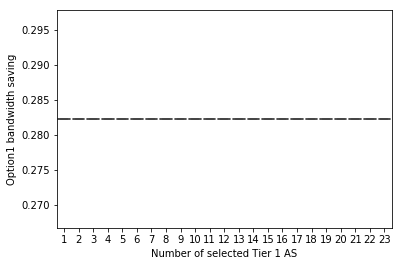

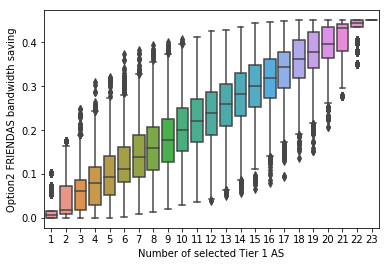

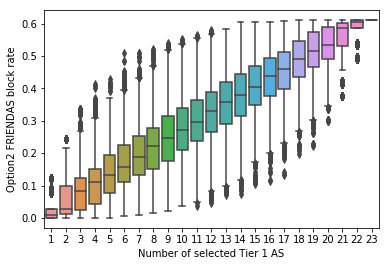

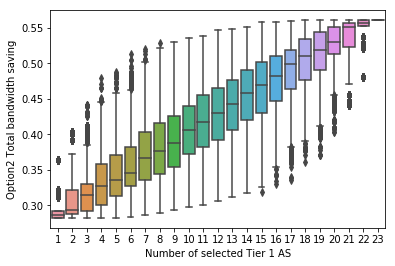

In [6]:


#####################################################################


def bandwidth_consume(stat: dict, fs_set, block_at_client_upstream=False, metric_func=None):
    total = .0
    fn = .0
    f_blocked = .0
    upstream_blocked = .0
    un = .0
    if fs_set is None:
        fs_set = set()
    if metric_func is None:
        metric_func = lambda x : x
    for c_stat in stat.values():
        for t in c_stat.values():
            metric = metric_func(t['vol'])
            total += metric *(len(t['route']) - 1)
            blocked = False
            i = 0
            for p in t['route'][:-1]:
                i += 1
                if p in fs_set:
                    blocked = True
                    break
            if blocked:
                fn += 1
                f_blocked += metric*(len(t['route']) - i)
            elif block_at_client_upstream:
                un += 1
                upstream_blocked += metric

    return total, fn, f_blocked, un, upstream_blocked


def select_f_as(n):
    tier1 = [7018,209,3356,3549,4323,3320,3257,4436,286,6830,2914,5511,3491,1239,6453,6762,12956,1299,701,702,703,2828,6461]
    return random.sample(tier1,n)


def filter_stub_as(stat):
    g = load_as_graph()
    stat1 = {}
    upstream = set()
    for k,v in stat.items():
        if int(k) not in g.nodes:
            continue
        adj = g.adj[int(k)]
        if all(a['rel']=='cp' for a in adj.values()):
            stat1[k] = v
            upstream.update(list(adj.keys()))
    return stat1, upstream


def block_traffic_sim(tmpfile):
    stat = json.load(open(tmpfile))
    stat, upstream = filter_stub_as(stat)
    data = []
    func = lambda x : 1
    for n in range(1,24):
        for i in range(10000):
            total, fn, f_blocked, un, upstream_blocked = bandwidth_consume(stat, None, True, func)
            r1 = upstream_blocked / total
            f_as = set(select_f_as(n))
            total, fn, f_blocked, un, upstream_blocked = bandwidth_consume(stat, f_as, True, func)
            r2 = f_blocked / total
            r3 = fn / (fn+un)
            r4 = (f_blocked + upstream_blocked)/total
            data.append([n, r1, r2, r3, r4])
    c0 = "Number of selected Tier 1 AS"
    c1 = "Option1 bandwidth saving"
    c2 = "Option2 FRIENDAS bandwidth saving"
    c3 = "Option2 FRIENDAS block rate"
    c4 = "Option2 Total bandwidth saving"
    df = pd.DataFrame(data, columns=[c0, c1, c2, c3, c4])

    def sim_plot(x, y, df):
        plt.clf()
        sns.boxplot(x=x, y=y, data=df)
        # plt.ylim([0.,1.])
        plt.show()
        # sns.plt.savefig("result/blocktraffic-unit.png", dpi=300, bbox_inches='tight')

    sim_plot(c0, c1, df)
    sim_plot(c0, c2, df)
    sim_plot(c0, c3, df)
    sim_plot(c0, c4, df)

block_traffic_sim(tmp)